<a href="https://colab.research.google.com/github/yakimsanik/belhard/blob/master/HW3/Yakim_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Загрузка и предварительный просмотр датасета

In [ ]:
import kagglehub

In [ ]:
# Download latest version
path = kagglehub.dataset_download("gauravkumar2525/shark-attacks")

print("Path to dataset files:", path)

100%|██████████| 285k/285k [00:00<00:00, 25.5MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/gauravkumar2525/shark-attacks/versions/1


In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Загрузка датасета
shark_attacks = pd.read_csv('/content/drive/MyDrive/Project/Data Science/HW3/global_shark_attacks.csv', encoding='latin1')

In [ ]:
# Предварительный просмотр данных
print(shark_attacks.head())
print("\nИнформация о датасете:")
print(shark_attacks.info())
print("\nОписательная статистика:")
print(shark_attacks.describe(include='all'))

         date    year        type    country                area  \
0  2023-05-13  2023.0  Unprovoked  AUSTRALIA     South Australia   
1  2023-04-29  2023.0  Unprovoked  AUSTRALIA   Western Australia   
2  2022-10-07  2022.0  Unprovoked  AUSTRALIA  Western  Australia   
3  2021-10-04  2021.0  Unprovoked        USA             Florida   
4  2021-10-03  2021.0  Unprovoked        USA             Florida   

                                   location      activity                name  \
0                                  Elliston       Surfing    Simon Baccanello   
1                      Yallingup, Busselton      Swimming                male   
2                              Port Hedland  Spearfishing         Robbie Peck   
3  Fort Pierce State Park, St. Lucie County       Surfing  Truman Van Patrick   
4               Jensen Beach, Martin County      Swimming                male   

  sex   age fatal_y_n   time      species  
0   M    46         Y  10h10  White shark  
1   M   NaN     

Предварительная обработка данных

In [ ]:
# Очистка данных
shark_attacks_clean = shark_attacks.copy()

# Удаление ненужных столбцов
cols_to_drop = ['Case Number', 'Investigator or Source', 'pdf', 'href formula',
                'href', 'Case Number.1', 'Case Number.2', 'original order',
                'Unnamed: 22', 'Unnamed: 23']
shark_attacks_clean.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# Преобразование даты
shark_attacks_clean['date'] = pd.to_datetime(shark_attacks_clean['date'], errors='coerce')

# Заполнение пропущенных значений
shark_attacks_clean['age'] = pd.to_numeric(shark_attacks_clean['age'], errors='coerce')
shark_attacks_clean['year'] = shark_attacks_clean['date'].dt.year

# Удаление строк с отсутствующей критической информацией
shark_attacks_clean = shark_attacks_clean.dropna(subset=['country', 'year'])

 Создание базы данных SQLite и таблицы

In [ ]:
# Создание базы данных
conn = sqlite3.connect('shark_attacks.db')
cursor = conn.cursor()

# Создание таблицы
cursor.execute('''
CREATE TABLE IF NOT EXISTS attacks (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    date TEXT,
    year REAL,
    type TEXT,
    country TEXT,
    area TEXT,
    location TEXT,
    activity TEXT,
    name TEXT,
    sex TEXT,
    age REAL,
    fatal TEXT,
    time TEXT,
    species TEXT
)
''')

# Импорт данных
shark_attacks_clean.to_sql('attacks', conn, if_exists='replace', index=False)
conn.commit()

SQL-запросы с фильтрацией

In [ ]:
# 10 самых последних атак
recent_attacks = pd.read_sql('''
SELECT date, country, activity, fatal_y_n
FROM attacks
WHERE date IS NOT NULL
ORDER BY date DESC
LIMIT 10
''', conn)
print("10 самых последних атак:")
print(recent_attacks)

# Смертельные атаки в США
usa_fatal = pd.read_sql('''
SELECT year, location, activity, age, sex
FROM attacks
WHERE country = 'USA' AND fatal_y_n = 'Y'
ORDER BY year DESC
''', conn)
print("\nСмертельные атаки в США:")
print(usa_fatal.head())

# Атаки на серферов
surfer_attacks = pd.read_sql('''
SELECT country, year, fatal_y_n, age
FROM attacks
WHERE activity LIKE '%surf%'
ORDER BY year DESC
''', conn)
print("\nАтаки на серферов:")
print(surfer_attacks.head())

10 самых последних атак:
                  date    country         activity fatal_y_n
0  2023-08-16 00:00:00      SPAIN           Wading         N
1  2023-08-16 00:00:00   PORTUGAL          Fishing         N
2  2023-08-07 00:00:00        USA           Wading         N
3  2023-07-31 00:00:00        USA          Surfing         N
4  2023-07-30 00:00:00        USA     Spearfishing         N
5  2023-07-29 00:00:00        USA         Swimming         N
6  2023-07-24 00:00:00  Australia          Surfing         N
7  2023-07-22 00:00:00  Australia       Snorkeling         N
8  2023-07-21 00:00:00        USA  Boogie boarding         N
9  2023-07-18 00:00:00   COLOMBIA       Freediving         N

Смертельные атаки в США:
     year                                  location         activity   age sex
0  2022.0              Keawakapu Point, Kehei, Maui       Snorkeling  60.0   F
1  2022.0  San Miguel Islandl, Santa Barbara County  Boogie boarding  42.0   M
2  2021.0        46 miles off Mayport, Du

SQL-запросы с агрегатными функциями

In [ ]:
# Количество атак по странам
attacks_by_country = pd.read_sql('''
SELECT country, COUNT(*) as attack_count
FROM attacks
GROUP BY country
ORDER BY attack_count DESC
LIMIT 10
''', conn)
print("\nТоп-10 стран по количеству атак:")
print(attacks_by_country)

# Средний возраст пострадавших по полу
avg_age_by_sex = pd.read_sql('''
SELECT sex, AVG(age) as avg_age, COUNT(*) as count
FROM attacks
WHERE age IS NOT NULL
GROUP BY sex
''', conn)
print("\nСредний возраст пострадавших по полу:")
print(avg_age_by_sex)

# Количество смертельных атак по годам
fatal_by_year = pd.read_sql('''
SELECT year, COUNT(*) as fatal_count
FROM attacks
WHERE fatal_y_n = 'Y' AND year IS NOT NULL
GROUP BY year
ORDER BY fatal_count DESC
LIMIT 10
''', conn)
print("\nГоды с наибольшим количеством смертельных атак:")
print(fatal_by_year)


Топ-10 стран по количеству атак:
            country  attack_count
0               USA          2467
1         AUSTRALIA          1421
2      SOUTH AFRICA           580
3       NEW ZEALAND           136
4  PAPUA NEW GUINEA           130
5           BAHAMAS           126
6            BRAZIL           120
7            MEXICO            95
8     NEW CALEDONIA            63
9             ITALY            61

Средний возраст пострадавших по полу:
    sex    avg_age  count
0  None  23.548387     31
1     F  27.664151    530
2     M  28.094560   3162
3   lli  38.000000      1

Годы с наибольшим количеством смертельных атак:
     year  fatal_count
0  1959.0           22
1  1956.0           19
2  1958.0           17
3  2000.0           16
4  1964.0           16
5  1962.0           15
6  2020.0           14
7  2011.0           14
8  2004.0           14
9  1993.0           14


Визуализация данных

<ipython-input-25-d7950a94b3d8>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='attack_count', y='country', data=attacks_by_country, palette='viridis')


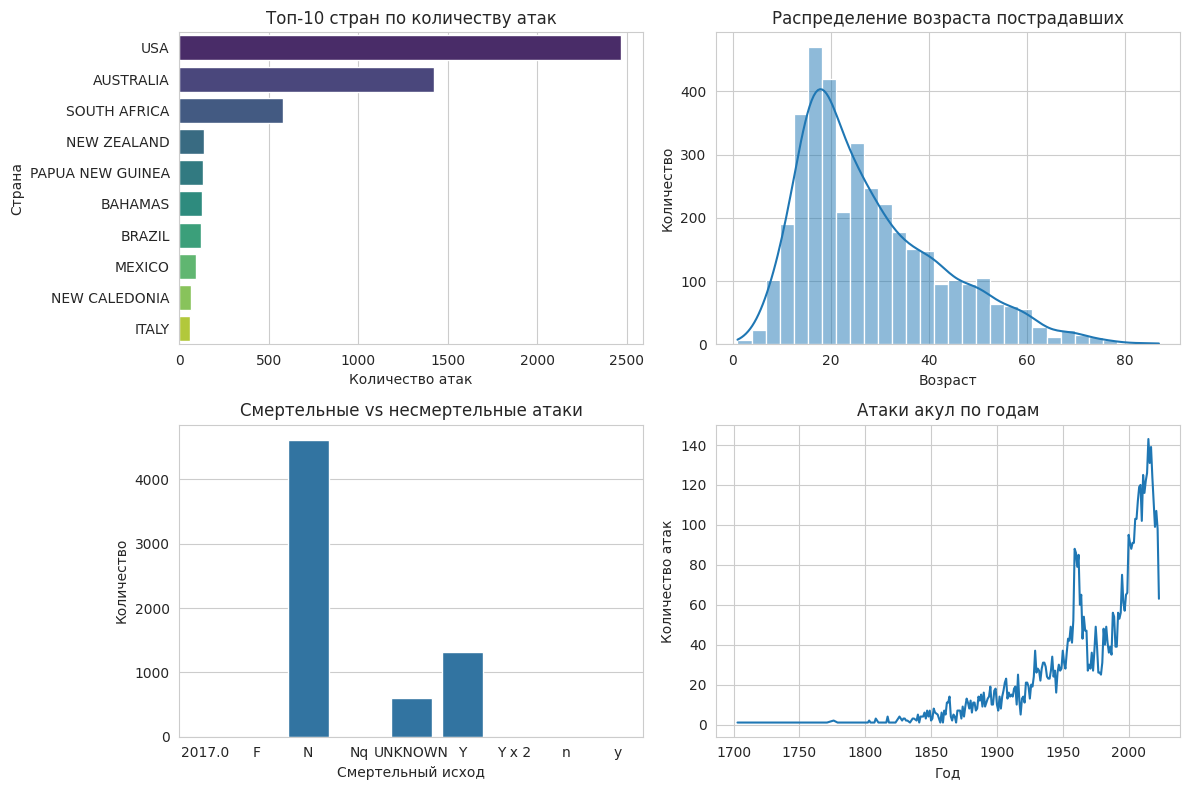

<ipython-input-25-d7950a94b3d8>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='activity', data=activity_counts, palette='rocket')


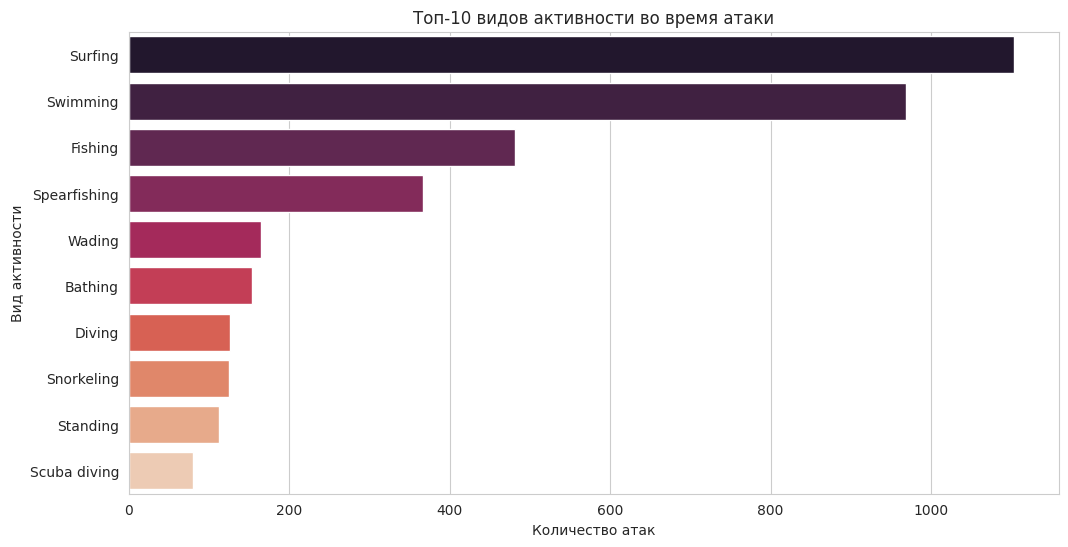

In [ ]:
# Настройка стиля
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

# 1. Количество атак по странам (топ-10)
plt.subplot(2, 2, 1)
sns.barplot(x='attack_count', y='country', data=attacks_by_country, palette='viridis')
plt.title('Топ-10 стран по количеству атак')
plt.xlabel('Количество атак')
plt.ylabel('Страна')

# 2. Распределение возраста пострадавших
plt.subplot(2, 2, 2)
age_data = pd.read_sql('SELECT age FROM attacks WHERE age IS NOT NULL', conn)
sns.histplot(age_data['age'], bins=30, kde=True)
plt.title('Распределение возраста пострадавших')
plt.xlabel('Возраст')
plt.ylabel('Количество')

# 3. Смертельные vs несмертельные атаки
plt.subplot(2, 2, 3)
fatal_counts = pd.read_sql('SELECT fatal_y_n, COUNT(*) as count FROM attacks GROUP BY fatal_y_n', conn)
sns.barplot(x='fatal_y_n', y='count', data=fatal_counts)
plt.title('Смертельные vs несмертельные атаки')
plt.xlabel('Смертельный исход')
plt.ylabel('Количество')

# 4. Атаки по годам
plt.subplot(2, 2, 4)
attacks_by_year = pd.read_sql('''
SELECT year, COUNT(*) as count
FROM attacks
WHERE year IS NOT NULL
GROUP BY year
ORDER BY year
''', conn)
sns.lineplot(x='year', y='count', data=attacks_by_year)
plt.title('Атаки акул по годам')
plt.xlabel('Год')
plt.ylabel('Количество атак')

plt.tight_layout()
plt.show()

# Дополнительная визуализация: активность во время атаки
plt.figure(figsize=(12, 6))
activity_counts = pd.read_sql('''
SELECT activity, COUNT(*) as count
FROM attacks
WHERE activity IS NOT NULL
GROUP BY activity
ORDER BY count DESC
LIMIT 10
''', conn)
sns.barplot(x='count', y='activity', data=activity_counts, palette='rocket')
plt.title('Топ-10 видов активности во время атаки')
plt.xlabel('Количество атак')
plt.ylabel('Вид активности')
plt.show()

# Закрытие соединения с базой данных
conn.close()